In [182]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 100)
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import datetime
import json
from shapely import wkt

In [2]:
#reading deeds
deeds = pd.read_csv("data/SR1A_deeds/deeds_00_21_classified.csv", low_memory=False)

In [3]:
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,inv,occ,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup
0,0,714,"CAMPOS, FATIMA J",428 WASHINGTON AVE,"CLIFFSIDE PARK, NJ 00000","RYBRM HOLDINGS LLC,",198 CENTRAL AVE,"EAST ORANGE, NJ 00000",269 LAKE ST,540.0,43.0,NaN,2,21300,121100,99800,6/30/20,6/15/20,20200,60066,200000.0,26.0,1603.0,0.0,5696854.0,1902.0,NaN,NaN,06/15/20,2020-06-15,2020.0,Newark,NJ,NaN,5696854.0,40.760210,-74.179184,POINT (580992.187359745 702002.124279135),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0
1,1,714,"92 TUXEDO LLC,",13 MUNICIPAL PLZ #629,"BLOOMFIELD, NJ 00000","AGOSTO, STEPHEN F & WIGGIN, MATTHEW",92-94 TUXEDO PKWY,"NEWARK, NJ 00000",92-94 TUXEDO PKWY,4266.0,32.0,NaN,2,29400,138100,108700,6/30/20,5/18/20,20200,60247,285000.0,7.0,1582.0,0.0,5696855.0,1929.0,NaN,NaN,05/18/20,2020-05-18,2020.0,Newark,NJ,NaN,5696855.0,40.737785,-74.243770,POINT (563125.4362055603 693773.8672076497),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1
2,2,714,"PAULINO, JOSE M & TOMMY E",940 MADISON AVE,"PATERSON, NJ 00000","LIZARDO-SEQUENCIA, JAIME",490-492 SUMMER AVE,"NEWARK, NJ 00000",490-492 SUMMER AVE,625.0,41.0,NaN,2,35200,199100,163900,6/29/20,6/18/20,20200,59815,400000.0,7.0,2942.0,0.0,5696851.0,1908.0,NaN,NaN,06/18/20,2020-06-18,2020.0,Newark,NJ,NaN,5696851.0,40.768337,-74.166880,POINT (584389.2136115041 704975.4918734678),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1
3,3,714,CARRINGTON MORTGAGE SERVICES LLC,1600 S DOUGLASS RD #130A,"ANAHEIM, CA 00000",684 S 20TH STREET LLC,684 S 20TH ST,"NEWARK, NJ 00000",684 S 20TH ST,355.0,40.0,NaN,2,31300,155200,123900,6/29/20,6/16/20,20200,59718,142000.0,13.0,2044.0,0.0,5696849.0,1915.0,NaN,NaN,06/16/20,2020-06-16,2020.0,Newark,NJ,NaN,5696849.0,40.736100,-74.212040,POINT (571919.7568863531 693187.3110322659),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0
4,4,714,"KARTZMAN, STEVEN P",101 GIBRALTAR DR #2F,"MORRIS PLAINS, NJ 00000","TONKA HOLDINGS 2 LLC,",303 S 19TH ST,"NEWARK, NJ 00000",303 S 19TH ST,1794.0,8.0,NaN,2,21300,101300,80000,6/29/20,6/10/20,20200,59491,175000.0,13.0,1786.0,0.0,5696846.0,1897.0,NaN,NaN,06/10/20,2020-06-10,2020.0,Newark,NJ,NaN,5696846.0,40.746513,-74.206904,POINT (573330.3148576431 696985.4117777911),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0


In [4]:
#ranking to find most recent deed change (labeled as 1)
deeds['deed_date_dt_x'] = pd.to_datetime(deeds['deed_date_dt_x'])
deeds['Rank'] = deeds.groupby('Property Location_x')['deed_date_dt_x'].rank(ascending=False)

In [5]:
#sorting based on street address and receipt date
deeds = deeds.sort_values(by=['Property Location_x','deed_date_dt_x'])

In [7]:
#finding the owernship period of a deed
deeds['own_period'] = deeds.groupby('Property Location_x')['deed_date_dt_x'].diff() / np.timedelta64(1, 'D')
deeds['own_period'] = deeds['own_period'].fillna(999)

In [8]:
#classifying as investor rental, investor flip, or non investor
deeds['classification'] = np.where((deeds.investor_all == 1) & 
                                              (deeds.Rank == 1.0) & 
                                              (deeds.own_period >= 575) &
                                              (deeds.inv == 1), 'institutional investor rental', 
                                              np.where((deeds.investor_all == 1) & 
                                                       (deeds.Rank == 1.0) & 
                                                       (deeds.own_period >= 575) &
                                                       (deeds.inv == 0), 'non institutional investor rental',
                                                       np.where((deeds.investor_all == 1) & 
                                                                (deeds.inv==1) &
                                                                (deeds.own_period < 575), 'institutional investor flip', 
                                                                np.where((deeds.investor_all == 1) &
                                                                         (deeds.own_period < 575) &
                                                                         (deeds.inv == 0),'non institutional investor flip', 'non investor'))))
deeds['classification'] = deeds['classification'].fillna('non investor')

## Exploring Differences Over Time

In [11]:
investor_single_family_rentals = deeds[(deeds['classification'] == 'institutional investor rental')
                                                |(deeds['classification'] == 'non institutional investor rental')]
investor_single_family_rentals_00_18 = investor_single_family_rentals[investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]
investor_flips = deeds[(deeds['classification'] == 'institutional investor flip')
                                                |(deeds['classification'] == 'non institutional investor flip')]
investor_flips_00_18 = investor_flips[investor_flips['deed_date_dt_x'].dt.year <= 2018]
owner_occupants = deeds[deeds['classification'] == 'non investor']
owner_occupants_00_18 = owner_occupants[owner_occupants['deed_date_dt_x'].dt.year <= 2018]

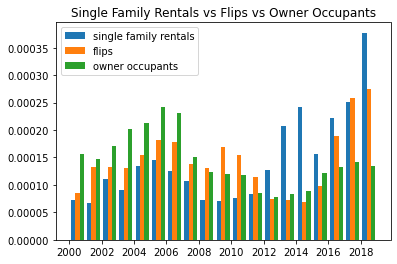

In [12]:
#plotting transactions by density
plt.title(label="Single Family Rentals vs Flips vs Owner Occupants")
plt.hist([investor_single_family_rentals_00_18['deed_date_dt_x'],investor_flips_00_18['deed_date_dt_x'],owner_occupants_00_18['deed_date_dt_x']],stacked=False, density=True, bins=19)
plt.legend(['single family rentals', 'flips', 'owner occupants'])

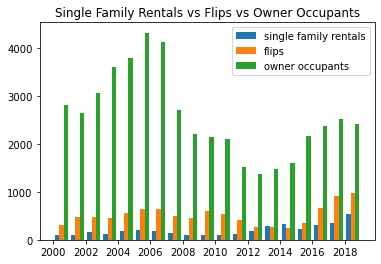

In [16]:
#plotting transactions by total value
plt.title(label="Single Family Rentals vs Flips vs Owner Occupants")
plt.hist([investor_single_family_rentals_00_18['deed_date_dt_x'],investor_flips_00_18['deed_date_dt_x'],owner_occupants_00_18['deed_date_dt_x']],stacked=False, density=False, bins=19)
plt.legend(['single family rentals', 'flips', 'owner occupants'])

In [13]:
institutional_investor_single_family_rentals = deeds[(deeds['classification'] == 'institutional investor rental')]
non_institutional_investor_single_family_rentals = deeds[(deeds['classification'] == 'non institutional investor rental')]

institutional_investor_single_family_rentals_00_18 = institutional_investor_single_family_rentals[institutional_investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]
non_institutional_investor_single_family_rentals_00_18 = non_institutional_investor_single_family_rentals[non_institutional_investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]

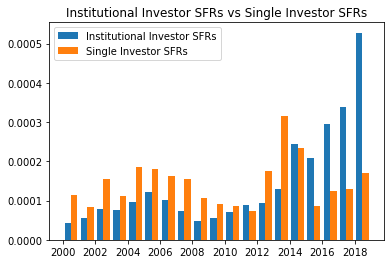

In [14]:
#investor breakdown by density
plt.title(label="Institutional Investor SFRs vs Single Investor SFRs")
plt.hist([institutional_investor_single_family_rentals_00_18['deed_date_dt_x'],non_institutional_investor_single_family_rentals_00_18['deed_date_dt_x']], stacked=False,density=True, bins=19)
plt.legend(['Institutional Investor SFRs', 'Single Investor SFRs'])

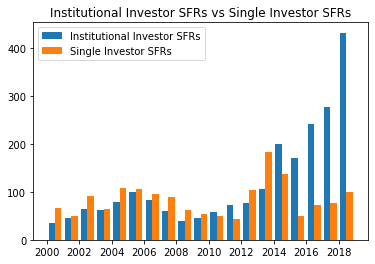

In [15]:
investor breakdown by total
plt.title(label="Institutional Investor SFRs vs Single Investor SFRs")
plt.hist([institutional_investor_single_family_rentals_00_18['deed_date_dt_x'],non_institutional_investor_single_family_rentals_00_18['deed_date_dt_x']], stacked=False,density=False, bins=19)
plt.legend(['Institutional Investor SFRs', 'Single Investor SFRs'])

In [29]:
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,inv,occ,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank,own_period,classification
39122,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,NaN,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,NaN,NaN,08/31/06,2006-08-31,2006.0,Newark,NJ,NaN,9111930.0,40.741497,-74.220240,POINT (569641.2266989056 695146.0638159891),False,0,1,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13,13.0,1.0,1.0,0,1.0,999.0,non institutional investor rental
46429,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,NaN,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,NaN,NaN,06/15/05,2005-06-15,2005.0,Newark,NJ,NaN,8604346.0,40.760153,-74.190428,POINT (577877.565242357 701970.0137778884),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1,1.0,999.0,non investor
57744,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,NaN,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,NaN,NaN,01/03/02,2002-01-03,2002.0,Newark,NJ,NaN,7053068.0,40.748870,-74.169055,POINT (583813.4924992458 697881.2696454047),False,0,1,NaN,NaN,NaN,NaN,999,NaN,NaN,0.0,1,1.0,999.0,non investor
8037,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119549.0,40.779507,-74.171120,POINT (583199.6019454151 709040.2792985266),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0,1.5,999.0,non investor
8038,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119550.0,40.779507,-74.171120,POINT (583199.6019454151 709040.2792985266),True,1,0,NaN,NaN,NaN,NaN,999,NaN,NaN,1.0,0,1.5,0.0,institutional investor flip


In [36]:
deeds['geometry'] = deeds['geometry'].apply(wkt.loads)

In [37]:
deeds_classified = gpd.GeoDataFrame(deeds, geometry = deeds['geometry'], crs = 'epsg:3424')

In [39]:
# saving final list of grantees
deeds_classified.to_file("data/SR1A_deeds/deeds_investors_rentals_flips.geojson", driver = "GeoJSON")

## Reimport geojson of classified deeds

In [69]:
#read in classified deeds file
deeds_classified = gpd.read_file("data/SR1A_deeds/deeds_investors_rentals_flips.geojson")


In [70]:
deeds_classified['count_field'] = 1
deeds_classified['year'] = deeds_classified['year'].astype(str).replace('\.0', '', regex=True)

In [71]:
deeds_classified['institutional_investor_rental'] = np.where(deeds_classified['classification'].str.contains('institutional investor rental', regex=True),1, 0)
deeds_classified['non_institutional_investor_rental'] = np.where(deeds_classified['classification'].str.contains('non institutional investor rental', regex=True),1, 0)
deeds_classified['institutional_investor_flip'] = np.where(deeds_classified['classification'].str.contains('institutional investor flip', regex=True),1, 0)
deeds_classified['non_institutional_investor_flip'] = np.where(deeds_classified['classification'].str.contains('non institutional investor flip', regex=True),1, 0)
deeds_classified['non_investor'] = np.where(deeds_classified['classification'].str.contains('non investor', regex=True),1, 0)

In [72]:
deeds_classified.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,grantee_y,inv,occ,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank,own_period,classification,geometry,count_field,institutional_investor_rental,non_institutional_investor_rental,institutional_investor_flip,non_institutional_investor_flip,non_investor
0,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,None,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,None,None,08/31/06,2006-08-31T00:00:00,2006,Newark,NJ,None,9111930.0,40.741497,-74.220240,False,0,1,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13,13.0,1.0,1.0,0,1.0,999.0,non institutional investor rental,POINT (569641.227 695146.064),1,1,1,0,0,0
1,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,None,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,None,None,06/15/05,2005-06-15T00:00:00,2005,Newark,NJ,None,8604346.0,40.760153,-74.190428,False,0,1,None,None,None,None,999,NaN,NaN,0.0,1,1.0,999.0,non investor,POINT (577877.565 701970.014),1,0,0,0,0,1
2,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,None,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,None,None,01/03/02,2002-01-03T00:00:00,2002,Newark,NJ,None,7053068.0,40.748870,-74.169055,False,0,1,None,None,None,None,999,NaN,NaN,0.0,1,1.0,999.0,non investor,POINT (583813.492 697881.270),1,0,0,0,0,1
3,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,None,None,03/23/18,2018-03-23T00:00:00,2018,Newark,NJ,None,5119549.0,40.779507,-74.171120,True,1,0,None,None,None,None,999,NaN,NaN,1.0,0,1.5,999.0,non investor,POINT (583199.602 709040.279),1,0,0,0,0,1
4,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,None,None,03/23/18,2018-03-23T00:00:00,2018,Newark,NJ,None,5119550.0,40.779507,-74.171120,True,1,0,None,None,None,None,999,NaN,NaN,1.0,0,1.5,0.0,institutional investor flip,POINT (583199.602 709040.279),1,0,0,1,0,0


In [93]:
res_properties = gpd.read_file("data/newark_parcels/Lot_Area.shp")

In [94]:
res_properties = res_properties.to_crs('epsg:3424')

In [95]:
res_properties_counts = res_properties[['ID', 'geometry']]

In [96]:
res_properties_counts = res_properties_counts.rename(columns = {'ID':'res_parcel_num'})

In [52]:
tracts = gpd.read_file('data/newark_tracts/newarktractpolygon.geojson')

In [46]:
wards = gpd.read_file('data/newark_wards/Wards_2012.shp')

In [53]:
#reprojecting tracts
tracts = tracts.to_crs('epsg:3424')

In [48]:
#reprojecting wards
wards = wards.to_crs('epsg:3424')

## Spatial Join between Deeds and Wards

In [73]:
deeds_tracts = gpd.sjoin(tracts, deeds_classified, how='left', op='intersects').reset_index()

In [74]:
#getting counts of purchases by type for year block for each year

grouped_deeds = deeds_tracts.groupby(['GEOID', 'year']).agg({'institutional_investor_rental':'sum',
                                                        'non_institutional_investor_rental':'sum',
                                                        'institutional_investor_flip':'sum', 'non_institutional_investor_flip':'sum',
                                                        'non_investor':'sum','count_field':'count'}).unstack()

In [75]:
# unstacking the grouped columns
new_cols = [''.join(t) for t in grouped_deeds.columns]
grouped_deeds.columns = new_cols

In [76]:
grouped_deeds.head()

,institutional_investor_rental2000,institutional_investor_rental2001,institutional_investor_rental2002,institutional_investor_rental2003,institutional_investor_rental2004,institutional_investor_rental2005,institutional_investor_rental2006,institutional_investor_rental2007,institutional_investor_rental2008,institutional_investor_rental2009,institutional_investor_rental2010,institutional_investor_rental2011,institutional_investor_rental2012,institutional_investor_rental2013,institutional_investor_rental2014,institutional_investor_rental2015,institutional_investor_rental2016,institutional_investor_rental2017,institutional_investor_rental2018,institutional_investor_rental2019,institutional_investor_rental2020,non_institutional_investor_rental2000,non_institutional_investor_rental2001,non_institutional_investor_rental2002,non_institutional_investor_rental2003,non_institutional_investor_rental2004,non_institutional_investor_rental2005,non_institutional_investor_rental2006,non_institutional_investor_rental2007,non_institutional_investor_rental2008,non_institutional_investor_rental2009,non_institutional_investor_rental2010,non_institutional_investor_rental2011,non_institutional_investor_rental2012,non_institutional_investor_rental2013,non_institutional_investor_rental2014,non_institutional_investor_rental2015,non_institutional_investor_rental2016,non_institutional_investor_rental2017,non_institutional_investor_rental2018,non_institutional_investor_rental2019,non_institutional_investor_rental2020,institutional_investor_flip2000,institutional_investor_flip2001,institutional_investor_flip2002,institutional_investor_flip2003,institutional_investor_flip2004,institutional_investor_flip2005,institutional_investor_flip2006,institutional_investor_flip2007,...,non_institutional_investor_flip2013,non_institutional_investor_flip2014,non_institutional_investor_flip2015,non_institutional_investor_flip2016,non_institutional_investor_flip2017,non_institutional_investor_flip2018,non_institutional_investor_flip2019,non_institutional_investor_flip2020,non_investor2000,non_investor2001,non_investor2002,non_investor2003,non_investor2004,non_investor2005,non_investor2006,non_investor2007,non_investor2008,non_investor2009,non_investor2010,non_investor2011,non_investor2012,non_investor2013,non_investor2014,non_investor2015,non_investor2016,non_investor2017,non_investor2018,non_investor2019,non_investor2020,count_field2000,count_field2001,count_field2002,count_field2003,count_field2004,count_field2005,count_field2006,count_field2007,count_field2008,count_field2009,count_field2010,count_field2011,count_field2012,count_field2013,count_field2014,count_field2015,count_field2016,count_field2017,count_field2018,count_field2019,count_field2020
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34013000100,1.0,1.0,3.0,4.0,2.0,0.0,0.0,2.0,2.0,4.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,14.0,4.0,3.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,5.0,3.0,0.0,2.0,5.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,57.0,60.0,70.0,100.0,75.0,90.0,80.0,51.0,31.0,34.0,35.0,27.0,28.0,27.0,29.0,50.0,53.0,56.0,61.0,42.0,11.0,60.0,66.0,76.0,104.0,79.0,95.0,83.0,56.0,40.0,38.0,36.0,29.0,29.0,29.0,31.0,51.0,54.0,63.0,100.0,52.0,14.0
34013000200,1.0,4.0,2.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0,4.0,0.0,0.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0,5.0,1.0,4.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,20.0,21.0,31.0,29.0,24.0,32.0,40.0,19.0,15.0,19.0,11.0,10.0,9.0,7.0,16.0,11.0,16.0,14.0,20.0,13.0,1.0,23.0,27.0,34.0,35.0,26.0,37.0,43.0,21.0,16.0,20.0,16.0,15.0,14.0,10.0,20.0,12.0,18.0,21.0,26.0,19.0,3.0
34013000300,3.0,0.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0,2.0,0.0,1.0,5.0,0.0,6.0,0.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,8.0,3.0,6.0,3.0,2.0,...,3.0,1.0

In [77]:
tract_geometry = tracts[['GEOID', 'geometry']]

In [78]:
#merging groupd blocks with geometry field
grouped_deeds = tract_geometry.merge(grouped_deeds, how='left', left_on="GEOID", right_on="GEOID")

#converting to a geodataframe
grouped_deeds = gpd.GeoDataFrame(grouped_deeds, geometry = grouped_deeds['geometry'])


In [97]:
# joining residential parcels from Lot Area to tracts to have count of parcels
res_tracts = gpd.sjoin(tracts, res_properties_counts, how='left', op='intersects').reset_index()

In [98]:
res_tracts.head()

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,index_right,res_parcel_num
0,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",26538,30423
1,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",26034,30464
2,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",25506,30484
3,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",25500,30471
4,0,34,013,002100,34013002100,21,Census Tract 21,G5020,S,438124.0,0.0,+40.7432012,-074.2346148,"MULTIPOLYGON (((564065.678 694925.704, 564450....",25446,30450


In [99]:
res_count = res_tracts.groupby(['GEOID']).agg({'res_parcel_num':'count'}).reset_index()

In [100]:
grouped_deeds = grouped_deeds.merge(res_count, how="left", left_on='GEOID', right_on='GEOID')

## Calculating percent by classification purchases per tract per year

In [101]:
# percent of purchases by block that are institutional investor purchases for rentals
#2000
grouped_deeds['per_inst_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_inst_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_inst_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_inst_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_inst_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_inst_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_inst_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_inst_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_inst_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_inst_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_inst_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_inst_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_inst_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_inst_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_inst_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_inst_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_inst_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_inst_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_inst_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

### non institutional investor rentals

In [102]:
# percent of purchases by block that are non-institutional investor purchases for rentals
#2000
grouped_deeds['per_non_inst_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inst_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inst_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inst_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inst_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inst_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inst_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inst_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inst_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inst_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inst_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inst_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inst_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inst_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inst_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inst_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inst_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inst_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inst_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

### institutional investor flip

In [103]:
# percent of purchases by block that are institutional investor purchases for flip
#2000
grouped_deeds['per_inst_inv_flip_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_inst_inv_flip_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_inst_inv_flip_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_inst_inv_flip_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_inst_inv_flip_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_inst_inv_flip_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_inst_inv_flip_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_inst_inv_flip_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_inst_inv_flip_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_inst_inv_flip_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_inst_inv_flip_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_inst_inv_flip_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_inst_inv_flip_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_inst_inv_flip_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_inst_inv_flip_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_inst_inv_flip_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_inst_inv_flip_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_inst_inv_flip_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_inst_inv_flip_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

### non institutional investor flip

In [104]:
# percent of purchases by block that are non-institutional investor purchases for flip
#2000
grouped_deeds['per_non_inst_inv_flip_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inst_inv_flip_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inst_inv_flip_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inst_inv_flip_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inst_inv_flip_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inst_inv_flip_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inst_inv_flip_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inst_inv_flip_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inst_inv_flip_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inst_inv_flip_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inst_inv_flip_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inst_inv_flip_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inst_inv_flip_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inst_inv_flip_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inst_inv_flip_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inst_inv_flip_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inst_inv_flip_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inst_inv_flip_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inst_inv_flip_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

### percent non investor/owner occupied

In [105]:
# percent of purchases by block that are non-investor purchases for owner occupation
#2000
grouped_deeds['per_non_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_investor2018']/x['res_parcel_num'], axis=1)

In [107]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var = [i for i in grouped_deeds.columns]


var.remove('geometry')

In [108]:
grouped_deeds = grouped_deeds.fillna({f:0 for f in var})

In [109]:
##saving grouped deeds as checkpoint
grouped_deeds.to_file('data/PROCESSED/grouped_deeds_tracts.geojson',driver="GeoJSON")

In [110]:
## can read grouped deeds in from here.....
grouped_deeds = gpd.read_file('data/PROCESSED/grouped_deeds_tracts.geojson')

In [111]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [112]:
# creating spatial weight for tracts
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weighted equally and 
# everything outside is considered not related/not a neighbor 
weight = DistanceBand.from_dataframe(grouped_deeds, threshold=2640)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 8 disconnected observations 
  Island ids: 22, 40, 41, 47, 59, 63, 69, 70
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


## Global Moran

In [129]:
## 2000-2010
global_moran_inst_rent = Moran.by_col(grouped_deeds,
       ['per_inst_inv_2000','per_inst_inv_2001','per_inst_inv_2002',
       'per_inst_inv_2003','per_inst_inv_2004','per_inst_inv_2005',
       'per_inst_inv_2006','per_inst_inv_2007','per_inst_inv_2008',
       'per_inst_inv_2009','per_inst_inv_2010','per_inst_inv_2011','per_inst_inv_2012',
       'per_inst_inv_2013','per_inst_inv_2014','per_inst_inv_2015',
       'per_inst_inv_2016','per_inst_inv_2017','per_inst_inv_2018'],w=weight, inplace=False)
global_moran_non_inst_rent = Moran.by_col(grouped_deeds,
       ['per_non_inst_inv_2000','per_non_inst_inv_2001','per_non_inst_inv_2002',
       'per_non_inst_inv_2003','per_non_inst_inv_2004','per_non_inst_inv_2005',
       'per_non_inst_inv_2006','per_non_inst_inv_2007','per_non_inst_inv_2008',
       'per_non_inst_inv_2009','per_non_inst_inv_2010','per_non_inst_inv_2011','per_non_inst_inv_2012',
       'per_non_inst_inv_2013','per_non_inst_inv_2014','per_non_inst_inv_2015',
       'per_non_inst_inv_2016','per_non_inst_inv_2017','per_non_inst_inv_2018'],w=weight, inplace=False)
global_moran_inst_flip = Moran.by_col(grouped_deeds,
       ['per_inst_inv_flip_2000','per_inst_inv_flip_2001','per_inst_inv_flip_2002',
       'per_inst_inv_flip_2003','per_inst_inv_flip_2004','per_inst_inv_flip_2005',
       'per_inst_inv_flip_2006','per_inst_inv_flip_2007','per_inst_inv_flip_2008',
       'per_inst_inv_flip_2009','per_inst_inv_flip_2010','per_inst_inv_flip_2011','per_inst_inv_flip_2012',
       'per_inst_inv_flip_2013','per_inst_inv_flip_2014','per_inst_inv_flip_2015',
       'per_inst_inv_flip_2016','per_inst_inv_flip_2017','per_inst_inv_flip_2018'],w=weight, inplace=False)
global_moran_non_inst_flip = Moran.by_col(grouped_deeds,
       ['per_non_inst_inv_flip_2000','per_non_inst_inv_flip_2001','per_non_inst_inv_flip_2002',
       'per_non_inst_inv_flip_2003','per_non_inst_inv_flip_2004','per_non_inst_inv_flip_2005',
       'per_non_inst_inv_flip_2006','per_non_inst_inv_flip_2007','per_non_inst_inv_flip_2008',
       'per_non_inst_inv_flip_2009', 'per_non_inst_inv_flip_2010','per_non_inst_inv_flip_2011','per_non_inst_inv_flip_2012',
       'per_non_inst_inv_flip_2013','per_non_inst_inv_flip_2014','per_non_inst_inv_flip_2015',
       'per_non_inst_inv_flip_2016','per_non_inst_inv_flip_2017','per_non_inst_inv_flip_2018'],w=weight, inplace=False)
global_moran_non_inv = Moran.by_col(grouped_deeds,
       ['per_non_inv_2000','per_non_inv_2001','per_non_inv_2002',
       'per_non_inv_2003','per_non_inv_2004','per_non_inv_2005',
       'per_non_inv_2006','per_non_inv_2007','per_non_inv_2008',
       'per_non_inv_2009','per_non_inv_2010','per_non_inv_2011','per_non_inv_2012',
       'per_non_inv_2013','per_non_inv_2014','per_non_inv_2015',
       'per_non_inv_2016','per_non_inv_2017','per_non_inv_2018'],w=weight, inplace=False)

In [130]:
# formatting results into a single table with global moran's results for each year
keep_inst_rent = ['per_inst_inv_2000_moran', 'per_inst_inv_2000_p_sim',
       'per_inst_inv_2001_moran', 'per_inst_inv_2001_p_sim', 'per_inst_inv_2002_moran',
       'per_inst_inv_2002_p_sim', 'per_inst_inv_2003_moran', 'per_inst_inv_2003_p_sim',
       'per_inst_inv_2004_moran', 'per_inst_inv_2004_p_sim', 'per_inst_inv_2005_moran',
       'per_inst_inv_2005_p_sim', 'per_inst_inv_2006_moran', 'per_inst_inv_2006_p_sim',
       'per_inst_inv_2007_moran', 'per_inst_inv_2007_p_sim', 'per_inst_inv_2008_moran',
       'per_inst_inv_2008_p_sim', 'per_inst_inv_2009_moran', 'per_inst_inv_2009_p_sim','per_inst_inv_2010_moran', 'per_inst_inv_2010_p_sim',
       'per_inst_inv_2011_moran', 'per_inst_inv_2011_p_sim', 'per_inst_inv_2012_moran',
       'per_inst_inv_2012_p_sim', 'per_inst_inv_2013_moran', 'per_inst_inv_2013_p_sim',
       'per_inst_inv_2014_moran', 'per_inst_inv_2014_p_sim', 'per_inst_inv_2015_moran',
       'per_inst_inv_2015_p_sim', 'per_inst_inv_2016_moran', 'per_inst_inv_2016_p_sim',
       'per_inst_inv_2017_moran', 'per_inst_inv_2017_p_sim', 'per_inst_inv_2018_moran',
       'per_inst_inv_2018_p_sim']
keep_non_inst_rent = ['per_non_inst_inv_2000_moran', 'per_non_inst_inv_2000_p_sim',
       'per_non_inst_inv_2001_moran', 'per_non_inst_inv_2001_p_sim', 'per_non_inst_inv_2002_moran',
       'per_non_inst_inv_2002_p_sim', 'per_non_inst_inv_2003_moran', 'per_non_inst_inv_2003_p_sim',
       'per_non_inst_inv_2004_moran', 'per_non_inst_inv_2004_p_sim', 'per_non_inst_inv_2005_moran',
       'per_non_inst_inv_2005_p_sim', 'per_non_inst_inv_2006_moran', 'per_non_inst_inv_2006_p_sim',
       'per_non_inst_inv_2007_moran', 'per_non_inst_inv_2007_p_sim', 'per_non_inst_inv_2008_moran',
       'per_non_inst_inv_2008_p_sim', 'per_non_inst_inv_2009_moran', 'per_non_inst_inv_2009_p_sim','per_non_inst_inv_2010_moran', 'per_non_inst_inv_2010_p_sim',
       'per_non_inst_inv_2011_moran', 'per_non_inst_inv_2011_p_sim', 'per_non_inst_inv_2012_moran',
       'per_non_inst_inv_2012_p_sim', 'per_non_inst_inv_2013_moran', 'per_non_inst_inv_2013_p_sim',
       'per_non_inst_inv_2014_moran', 'per_non_inst_inv_2014_p_sim', 'per_non_inst_inv_2015_moran',
       'per_non_inst_inv_2015_p_sim', 'per_non_inst_inv_2016_moran', 'per_non_inst_inv_2016_p_sim',
       'per_non_inst_inv_2017_moran', 'per_non_inst_inv_2017_p_sim', 'per_non_inst_inv_2018_moran',
       'per_non_inst_inv_2018_p_sim']
keep_inst_flip = ['per_inst_inv_flip_2000_moran', 'per_inst_inv_flip_2000_p_sim',
       'per_inst_inv_flip_2001_moran', 'per_inst_inv_flip_2001_p_sim', 'per_inst_inv_flip_2002_moran',
       'per_inst_inv_flip_2002_p_sim', 'per_inst_inv_flip_2003_moran', 'per_inst_inv_flip_2003_p_sim',
       'per_inst_inv_flip_2004_moran', 'per_inst_inv_flip_2004_p_sim', 'per_inst_inv_flip_2005_moran',
       'per_inst_inv_flip_2005_p_sim', 'per_inst_inv_flip_2006_moran', 'per_inst_inv_flip_2006_p_sim',
       'per_inst_inv_flip_2007_moran', 'per_inst_inv_flip_2007_p_sim', 'per_inst_inv_flip_2008_moran',
       'per_inst_inv_flip_2008_p_sim', 'per_inst_inv_flip_2009_moran', 'per_inst_inv_flip_2009_p_sim','per_inst_inv_flip_2010_moran', 'per_inst_inv_flip_2010_p_sim',
       'per_inst_inv_flip_2011_moran', 'per_inst_inv_flip_2011_p_sim', 'per_inst_inv_flip_2012_moran',
       'per_inst_inv_flip_2012_p_sim', 'per_inst_inv_flip_2013_moran', 'per_inst_inv_flip_2013_p_sim',
       'per_inst_inv_flip_2014_moran', 'per_inst_inv_flip_2014_p_sim', 'per_inst_inv_flip_2015_moran',
       'per_inst_inv_flip_2015_p_sim', 'per_inst_inv_flip_2016_moran', 'per_inst_inv_flip_2016_p_sim',
       'per_inst_inv_flip_2017_moran', 'per_inst_inv_flip_2017_p_sim', 'per_inst_inv_flip_2018_moran',
       'per_inst_inv_flip_2018_p_sim']
keep_non_inst_flip = ['per_non_inst_inv_flip_2000_moran', 'per_non_inst_inv_flip_2000_p_sim',
       'per_non_inst_inv_flip_2001_moran', 'per_non_inst_inv_flip_2001_p_sim', 'per_non_inst_inv_flip_2002_moran',
       'per_non_inst_inv_flip_2002_p_sim', 'per_non_inst_inv_flip_2003_moran', 'per_non_inst_inv_flip_2003_p_sim',
       'per_non_inst_inv_flip_2004_moran', 'per_non_inst_inv_flip_2004_p_sim', 'per_non_inst_inv_flip_2005_moran',
       'per_non_inst_inv_flip_2005_p_sim', 'per_non_inst_inv_flip_2006_moran', 'per_non_inst_inv_flip_2006_p_sim',
       'per_non_inst_inv_flip_2007_moran', 'per_non_inst_inv_flip_2007_p_sim', 'per_non_inst_inv_flip_2008_moran',
       'per_non_inst_inv_flip_2008_p_sim', 'per_non_inst_inv_flip_2009_moran', 'per_non_inst_inv_flip_2009_p_sim','per_non_inst_inv_flip_2010_moran', 'per_non_inst_inv_flip_2010_p_sim',
       'per_non_inst_inv_flip_2011_moran', 'per_non_inst_inv_flip_2011_p_sim', 'per_non_inst_inv_flip_2012_moran',
       'per_non_inst_inv_flip_2012_p_sim', 'per_non_inst_inv_flip_2013_moran', 'per_non_inst_inv_flip_2013_p_sim',
       'per_non_inst_inv_flip_2014_moran', 'per_non_inst_inv_flip_2014_p_sim', 'per_non_inst_inv_flip_2015_moran',
       'per_non_inst_inv_flip_2015_p_sim', 'per_non_inst_inv_flip_2016_moran', 'per_non_inst_inv_flip_2016_p_sim',
       'per_non_inst_inv_flip_2017_moran', 'per_non_inst_inv_flip_2017_p_sim', 'per_non_inst_inv_flip_2018_moran',
       'per_non_inst_inv_flip_2018_p_sim']
keep_non_inv = ['per_non_inv_2000_moran', 'per_non_inv_2000_p_sim',
       'per_non_inv_2001_moran', 'per_non_inv_2001_p_sim', 'per_non_inv_2002_moran',
       'per_non_inv_2002_p_sim', 'per_non_inv_2003_moran', 'per_non_inv_2003_p_sim',
       'per_non_inv_2004_moran', 'per_non_inv_2004_p_sim', 'per_non_inv_2005_moran',
       'per_non_inv_2005_p_sim', 'per_non_inv_2006_moran', 'per_non_inv_2006_p_sim',
       'per_non_inv_2007_moran', 'per_non_inv_2007_p_sim', 'per_non_inv_2008_moran',
       'per_non_inv_2008_p_sim', 'per_non_inv_2009_moran', 'per_non_inv_2009_p_sim','per_non_inv_2010_moran', 'per_non_inv_2010_p_sim',
       'per_non_inv_2011_moran', 'per_non_inv_2011_p_sim', 'per_non_inv_2012_moran',
       'per_non_inv_2012_p_sim', 'per_non_inv_2013_moran', 'per_non_inv_2013_p_sim',
       'per_non_inv_2014_moran', 'per_non_inv_2014_p_sim', 'per_non_inv_2015_moran',
       'per_non_inv_2015_p_sim', 'per_non_inv_2016_moran', 'per_non_inv_2016_p_sim',
       'per_non_inv_2017_moran', 'per_non_inv_2017_p_sim', 'per_non_inv_2018_moran',
       'per_non_inv_2018_p_sim']


In [115]:
#institutional investor rentals 
global_moran_inst_rent = global_moran_inst_rent[keep_inst_rent]
global_moran_inst_rent = global_moran_inst_rent.loc[0]

global_moran_inst_rent = global_moran_inst_rent.to_frame()

global_moran_inst_rent = global_moran_inst_rent.reset_index()

global_moran_inst_rent['year'] = global_moran_inst_rent['index'].str[13:17]
global_moran_inst_rent['type'] = global_moran_inst_rent['index'].str[-5:]

global_moran_inst_rent_table = global_moran_inst_rent.pivot(index='year',columns='type', values =0)

In [116]:
global_moran_inst_rent_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.156479,-0.01466,0.375705,0.094331,0.149149,-0.037274,0.156382,0.13364,0.131314,-0.092086,0.300618,-0.005,0.192539,0.338014,0.068117,0.095552,0.378522,0.071689,0.21062
p_sim,0.025000,0.44900,0.002000,0.130000,0.046000,0.360000,0.031000,0.06000,0.060000,0.178000,0.001000,0.398,0.016000,0.001000,0.207000,0.127000,0.001000,0.175000,0.01500


In [126]:
#non-institutional investor rentals 
global_moran_non_inst_rent = global_moran_non_inst_rent[keep_non_inst_rent]
global_moran_non_inst_rent = global_moran_non_inst_rent.loc[0]

global_moran_non_inst_rent = global_moran_non_inst_rent.to_frame()

global_moran_non_inst_rent = global_moran_non_inst_rent.reset_index()

global_moran_non_inst_rent['year'] = global_moran_non_inst_rent['index'].str[17:21]
global_moran_non_inst_rent['type'] = global_moran_non_inst_rent['index'].str[-5:]

global_moran_non_inst_rent_table = global_moran_non_inst_rent.pivot(index='year',columns='type', values =0)

In [127]:
global_moran_non_inst_rent_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.181876,-0.118221,0.337608,0.057458,0.09804,-0.032488,-0.004041,0.13364,-0.017849,-0.03992,0.156029,-0.048494,0.163457,0.227407,0.067976,-0.09611,0.105242,-0.0041,0.09821
p_sim,0.020000,0.014000,0.001000,0.217000,0.05500,0.432000,0.444000,0.04700,0.498000,0.39500,0.043000,0.369000,0.031000,0.007000,0.172000,0.13400,0.103000,0.4370,0.10500


In [131]:
#institutional investor flips 
global_moran_inst_flip = global_moran_inst_flip[keep_inst_flip]
global_moran_inst_flip = global_moran_inst_flip.loc[0]

global_moran_inst_flip = global_moran_inst_flip.to_frame()

global_moran_inst_flip = global_moran_inst_flip.reset_index()

global_moran_inst_flip['year'] = global_moran_inst_flip['index'].str[18:22]
global_moran_inst_flip['type'] = global_moran_inst_flip['index'].str[-5:]

global_moran_inst_flip_table = global_moran_inst_flip.pivot(index='year',columns='type', values =0)

In [132]:
global_moran_inst_flip_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.286595,0.256947,0.437254,0.370756,0.408286,0.361938,0.547033,0.50828,0.482069,0.413807,0.43516,0.219252,0.346322,-0.051038,0.373766,0.485938,0.580982,0.511852,0.624055
p_sim,0.004000,0.002000,0.001000,0.001000,0.001000,0.001000,0.001000,0.00100,0.001000,0.001000,0.00100,0.012000,0.001000,0.312000,0.001000,0.001000,0.001000,0.001000,0.001000


In [133]:
#non_institutional investor flips 
global_moran_non_inst_flip = global_moran_non_inst_flip[keep_non_inst_flip]
global_moran_non_inst_flip = global_moran_non_inst_flip.loc[0]

global_moran_non_inst_flip = global_moran_non_inst_flip.to_frame()

global_moran_non_inst_flip = global_moran_non_inst_flip.reset_index()

global_moran_non_inst_flip['year'] = global_moran_non_inst_flip['index'].str[22:26]
global_moran_non_inst_flip['type'] = global_moran_non_inst_flip['index'].str[-5:]

global_moran_non_inst_flip_table = global_moran_non_inst_flip.pivot(index='year',columns='type', values =0)

In [134]:
global_moran_non_inst_flip_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.123536,0.254854,0.472686,0.324445,0.316351,0.266913,0.493425,0.392347,0.408863,0.376461,0.361447,0.160419,0.347205,0.138719,0.262807,0.03298,0.186015,0.112626,0.251579
p_sim,0.073000,0.007000,0.001000,0.001000,0.001000,0.003000,0.001000,0.001000,0.001000,0.001000,0.002000,0.024000,0.001000,0.036000,0.002000,0.30100,0.025000,0.075000,0.004000


In [135]:
#non_institutional investor flips 
global_moran_non_inv = global_moran_non_inv[keep_non_inv]
global_moran_non_inv = global_moran_non_inv.loc[0]

global_moran_non_inv = global_moran_non_inv.to_frame()

global_moran_non_inv = global_moran_non_inv.reset_index()

global_moran_non_inv['year'] = global_moran_non_inv['index'].str[12:16]
global_moran_non_inv['type'] = global_moran_non_inv['index'].str[-5:]

global_moran_non_inv_table = global_moran_non_inv.pivot(index='year',columns='type', values =0)

In [136]:
global_moran_non_inst_flip_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.123536,0.254854,0.472686,0.324445,0.316351,0.266913,0.493425,0.392347,0.408863,0.376461,0.361447,0.160419,0.347205,0.138719,0.262807,0.03298,0.186015,0.112626,0.251579
p_sim,0.073000,0.007000,0.001000,0.001000,0.001000,0.003000,0.001000,0.001000,0.001000,0.001000,0.002000,0.024000,0.001000,0.036000,0.002000,0.30100,0.025000,0.075000,0.004000


### functions to automate moran process

In [137]:
from pysal.explore.esda.moran import Moran_Local, Moran

def fast_global_morans(dataset, column, spatial_weight):  
    print(column)
    moran_val = Moran(dataset[column].values,spatial_weight)
    print(".I: ", moran_val.I, "p value: ", moran_val.p_sim)
    return(moran_val)
        
def fast_local_morans(dataset, column, spatial_weight):  
    print(column)
    return(Moran_Local(dataset[column].values,spatial_weight))

### calculating local morans i for tracts and percent inst investor purchases for rent

In [138]:
moran2000_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2000',weight)
moran2001_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2001',weight)
moran2002_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2002',weight)
moran2003_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2003',weight)
moran2004_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2004',weight)
moran2005_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2005',weight)
moran2006_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2006',weight)
moran2007_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2007',weight)
moran2008_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2008',weight)
moran2009_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2009',weight)

moran2010_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2010',weight)
moran2011_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2011',weight)
moran2012_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2012',weight)
moran2013_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2013',weight)
moran2014_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2014',weight)
moran2015_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2015',weight)
moran2016_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2016',weight)
moran2017_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2017',weight)
moran2018_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2018',weight)

per_inst_inv_2000
per_inst_inv_2001
per_inst_inv_2002
per_inst_inv_2003
per_inst_inv_2004
per_inst_inv_2005
per_inst_inv_2006
per_inst_inv_2007
per_inst_inv_2008
per_inst_inv_2009
per_inst_inv_2010
per_inst_inv_2011
per_inst_inv_2012
per_inst_inv_2013
per_inst_inv_2014
per_inst_inv_2015
per_inst_inv_2016
per_inst_inv_2017
per_inst_inv_2018


In [139]:
moran2000_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2000',weight)
moran2001_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2001',weight)
moran2002_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2002',weight)
moran2003_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2003',weight)
moran2004_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2004',weight)
moran2005_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2005',weight)
moran2006_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2006',weight)
moran2007_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2007',weight)
moran2008_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2008',weight)
moran2009_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2009',weight)

moran2010_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2010',weight)
moran2011_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2011',weight)
moran2012_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2012',weight)
moran2013_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2013',weight)
moran2014_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2014',weight)
moran2015_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2015',weight)
moran2016_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2016',weight)
moran2017_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2017',weight)
moran2018_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2018',weight)

per_non_inst_inv_2000
per_non_inst_inv_2001
per_non_inst_inv_2002
per_non_inst_inv_2003
per_non_inst_inv_2004
per_non_inst_inv_2005
per_non_inst_inv_2006
per_non_inst_inv_2007
per_non_inst_inv_2008
per_non_inst_inv_2009
per_non_inst_inv_2010
per_non_inst_inv_2011
per_non_inst_inv_2012
per_non_inst_inv_2013
per_non_inst_inv_2014
per_non_inst_inv_2015
per_non_inst_inv_2016
per_non_inst_inv_2017
per_non_inst_inv_2018


In [140]:
moran2000_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2000',weight)
moran2001_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2001',weight)
moran2002_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2002',weight)
moran2003_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2003',weight)
moran2004_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2004',weight)
moran2005_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2005',weight)
moran2006_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2006',weight)
moran2007_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2007',weight)
moran2008_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2008',weight)
moran2009_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2009',weight)

moran2010_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2010',weight)
moran2011_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2011',weight)
moran2012_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2012',weight)
moran2013_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2013',weight)
moran2014_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2014',weight)
moran2015_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2015',weight)
moran2016_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2016',weight)
moran2017_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2017',weight)
moran2018_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2018',weight)

per_inst_inv_flip_2000
per_inst_inv_flip_2001
per_inst_inv_flip_2002
per_inst_inv_flip_2003
per_inst_inv_flip_2004
per_inst_inv_flip_2005
per_inst_inv_flip_2006
per_inst_inv_flip_2007
per_inst_inv_flip_2008
per_inst_inv_flip_2009
per_inst_inv_flip_2010
per_inst_inv_flip_2011
per_inst_inv_flip_2012
per_inst_inv_flip_2013
per_inst_inv_flip_2014
per_inst_inv_flip_2015
per_inst_inv_flip_2016
per_inst_inv_flip_2017
per_inst_inv_flip_2018


In [141]:
moran2000_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2000',weight)
moran2001_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2001',weight)
moran2002_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2002',weight)
moran2003_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2003',weight)
moran2004_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2004',weight)
moran2005_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2005',weight)
moran2006_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2006',weight)
moran2007_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2007',weight)
moran2008_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2008',weight)
moran2009_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2009',weight)

moran2010_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2010',weight)
moran2011_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2011',weight)
moran2012_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2012',weight)
moran2013_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2013',weight)
moran2014_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2014',weight)
moran2015_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2015',weight)
moran2016_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2016',weight)
moran2017_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2017',weight)
moran2018_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2018',weight)

per_non_inst_inv_flip_2000
per_non_inst_inv_flip_2001
per_non_inst_inv_flip_2002
per_non_inst_inv_flip_2003
per_non_inst_inv_flip_2004
per_non_inst_inv_flip_2005
per_non_inst_inv_flip_2006
per_non_inst_inv_flip_2007
per_non_inst_inv_flip_2008
per_non_inst_inv_flip_2009
per_non_inst_inv_flip_2010
per_non_inst_inv_flip_2011
per_non_inst_inv_flip_2012
per_non_inst_inv_flip_2013
per_non_inst_inv_flip_2014
per_non_inst_inv_flip_2015
per_non_inst_inv_flip_2016
per_non_inst_inv_flip_2017
per_non_inst_inv_flip_2018


In [142]:
moran2000_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2000',weight)
moran2001_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2001',weight)
moran2002_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2002',weight)
moran2003_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2003',weight)
moran2004_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2004',weight)
moran2005_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2005',weight)
moran2006_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2006',weight)
moran2007_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2007',weight)
moran2008_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2008',weight)
moran2009_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2009',weight)

moran2010_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2010',weight)
moran2011_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2011',weight)
moran2012_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2012',weight)
moran2013_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2013',weight)
moran2014_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2014',weight)
moran2015_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2015',weight)
moran2016_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2016',weight)
moran2017_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2017',weight)
moran2018_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2018',weight)

per_non_inv_2000
per_non_inv_2001
per_non_inv_2002
per_non_inv_2003
per_non_inv_2004
per_non_inv_2005
per_non_inv_2006
per_non_inv_2007
per_non_inv_2008
per_non_inv_2009
per_non_inv_2010
per_non_inv_2011
per_non_inv_2012
per_non_inv_2013
per_non_inv_2014
per_non_inv_2015
per_non_inv_2016
per_non_inv_2017
per_non_inv_2018


### Finding hh blocks for local morans i

In [143]:
# function to create columns with True False values for whether a row is a HH cluster
# a given list of local morans objects
######
# note to self for later this could also be used to make a df with the quadrant values (i.e. hh,hl,ll,lh)
######
def hh_columns(dataframe,list_morans,names_morans,list_column_names):
# dataframe, is the dataframe you want to add columns to
# list_morans, is a list containing the local moran objects you want to compute for
# names_morans, is a list of the local moran objects as strings
# list_column_names, is a list of the column names you want to define

    def find_hh(list_morans,names_morans):
        list_hh = []
        keys = []
        for i,val in enumerate(list_morans):
#             print("morans values:"+ names_morans[i])
            keys.append(names_morans[i])
            sig = val.p_sim<0.05
            hh_geom = val.q==1*sig
            list_hh.append(hh_geom)
        dict_hh = {keys[i]:list_hh[i] for i in range(len(keys))}
        return(dict_hh)  

    def calc_hh_columns(dataframe,list_column_names,dict_hh):
        #dict_hh is a dictionary of values with morans T/F for whether the value is in a cluster
        new_df = dataframe.copy()
        dict_keys = []
        for key,value in dict_hh.items():
            dict_keys.append(key)
        for i,val in enumerate(list_column_names):
#             print("new column:" +val)
#             print("calculated from moran:" +dict_keys[i])
            new_df[val] = temp_dict[dict_keys[i]]
        return(new_df)
        
    temp_dict = find_hh(list_morans,names_morans)
    print("calculated hh clusters for given list of local morans i")
    return(calc_hh_columns(dataframe,list_column_names,temp_dict))
    



In [144]:
# Calculating for investors & owners 2000-2009
morans=[moran2000_loc_inst_inv_rent,moran2000_loc_non_inst_inv_rent,moran2000_loc_inst_inv_flip,moran2000_loc_non_inst_inv_flip,moran2000_loc_non_inv,
            moran2001_loc_inst_inv_rent,moran2001_loc_non_inst_inv_rent,moran2001_loc_inst_inv_flip,moran2001_loc_non_inst_inv_flip,moran2001_loc_non_inv,
            moran2002_loc_inst_inv_rent,moran2002_loc_non_inst_inv_rent,moran2002_loc_inst_inv_flip,moran2002_loc_non_inst_inv_flip,moran2002_loc_non_inv,
            moran2003_loc_inst_inv_rent,moran2003_loc_non_inst_inv_rent,moran2003_loc_inst_inv_flip,moran2003_loc_non_inst_inv_flip,moran2003_loc_non_inv,
            moran2004_loc_inst_inv_rent,moran2004_loc_non_inst_inv_rent,moran2004_loc_inst_inv_flip,moran2004_loc_non_inst_inv_flip,moran2004_loc_non_inv,
            moran2005_loc_inst_inv_rent,moran2005_loc_non_inst_inv_rent,moran2005_loc_inst_inv_flip,moran2005_loc_non_inst_inv_flip,moran2005_loc_non_inv,
            moran2006_loc_inst_inv_rent,moran2006_loc_non_inst_inv_rent,moran2006_loc_inst_inv_flip,moran2006_loc_non_inst_inv_flip,moran2006_loc_non_inv,
            moran2007_loc_inst_inv_rent,moran2007_loc_non_inst_inv_rent,moran2007_loc_inst_inv_flip,moran2007_loc_non_inst_inv_flip,moran2007_loc_non_inv,
            moran2008_loc_inst_inv_rent,moran2008_loc_non_inst_inv_rent,moran2008_loc_inst_inv_flip,moran2008_loc_non_inst_inv_flip,moran2008_loc_non_inv,
            moran2009_loc_inst_inv_rent,moran2009_loc_non_inst_inv_rent,moran2009_loc_inst_inv_flip,moran2009_loc_non_inst_inv_flip,moran2009_loc_non_inv,moran2010_loc_inst_inv_rent,moran2010_loc_non_inst_inv_rent,moran2010_loc_inst_inv_flip,moran2010_loc_non_inst_inv_flip,moran2010_loc_non_inv,
            moran2011_loc_inst_inv_rent,moran2011_loc_non_inst_inv_rent,moran2011_loc_inst_inv_flip,moran2011_loc_non_inst_inv_flip,moran2011_loc_non_inv,
            moran2012_loc_inst_inv_rent,moran2012_loc_non_inst_inv_rent,moran2012_loc_inst_inv_flip,moran2012_loc_non_inst_inv_flip,moran2012_loc_non_inv,
            moran2013_loc_inst_inv_rent,moran2013_loc_non_inst_inv_rent,moran2013_loc_inst_inv_flip,moran2013_loc_non_inst_inv_flip,moran2013_loc_non_inv,
            moran2014_loc_inst_inv_rent,moran2014_loc_non_inst_inv_rent,moran2014_loc_inst_inv_flip,moran2014_loc_non_inst_inv_flip,moran2014_loc_non_inv,
            moran2015_loc_inst_inv_rent,moran2015_loc_non_inst_inv_rent,moran2015_loc_inst_inv_flip,moran2015_loc_non_inst_inv_flip,moran2015_loc_non_inv,
            moran2016_loc_inst_inv_rent,moran2016_loc_non_inst_inv_rent,moran2016_loc_inst_inv_flip,moran2016_loc_non_inst_inv_flip,moran2016_loc_non_inv,
            moran2017_loc_inst_inv_rent,moran2017_loc_non_inst_inv_rent,moran2017_loc_inst_inv_flip,moran2017_loc_non_inst_inv_flip,moran2017_loc_non_inv,
            moran2018_loc_inst_inv_rent,moran2018_loc_non_inst_inv_rent,moran2018_loc_inst_inv_flip,moran2018_loc_non_inst_inv_flip,moran2018_loc_non_inv]

morans_names=['moran2000_loc_inst_inv_rent','moran2000_loc_non_inst_inv_rent','moran2000_loc_inst_inv_flip','moran2000_loc_non_inst_inv_flip','moran2000_loc_non_inv',
            'moran2001_loc_inst_inv_rent','moran2001_loc_non_inst_inv_rent','moran2001_loc_inst_inv_flip','moran2001_loc_non_inst_inv_flip','moran2001_loc_non_inv',
            'moran2002_loc_inst_inv_rent','moran2002_loc_non_inst_inv_rent','moran2002_loc_inst_inv_flip','moran2002_loc_non_inst_inv_flip','moran2002_loc_non_inv',
            'moran2003_loc_inst_inv_rent','moran2003_loc_non_inst_inv_rent','moran2003_loc_inst_inv_flip','moran2003_loc_non_inst_inv_flip','moran2003_loc_non_inv',
            'moran2004_loc_inst_inv_rent','moran2004_loc_non_inst_inv_rent','moran2004_loc_inst_inv_flip','moran2004_loc_non_inst_inv_flip','moran2004_loc_non_inv',
            'moran2005_loc_inst_inv_rent','moran2005_loc_non_inst_inv_rent','moran2005_loc_inst_inv_flip','moran2005_loc_non_inst_inv_flip','moran2005_loc_non_inv',
            'moran2006_loc_inst_inv_rent','moran2006_loc_non_inst_inv_rent','moran2006_loc_inst_inv_flip','moran2006_loc_non_inst_inv_flip','moran2006_loc_non_inv',
            'moran2007_loc_inst_inv_rent','moran2007_loc_non_inst_inv_rent','moran2007_loc_inst_inv_flip','moran2007_loc_non_inst_inv_flip','moran2007_loc_non_inv',
            'moran2008_loc_inst_inv_rent','moran2008_loc_non_inst_inv_rent','moran2008_loc_inst_inv_flip','moran2008_loc_non_inst_inv_flip','moran2008_loc_non_inv',
            'moran2009_loc_inst_inv_rent','moran2009_loc_non_inst_inv_rent','moran2009_loc_inst_inv_flip','moran2009_loc_non_inst_inv_flip','moran2009_loc_non_inv','moran2010_loc_inst_inv_rent','moran2010_loc_non_inst_inv_rent','moran2010_loc_inst_inv_flip','moran2010_loc_non_inst_inv_flip','moran2010_loc_non_inv',
            'moran2011_loc_inst_inv_rent','moran2011_loc_non_inst_inv_rent','moran2011_loc_inst_inv_flip','moran2011_loc_non_inst_inv_flip','moran2011_loc_non_inv',
            'moran2012_loc_inst_inv_rent','moran2012_loc_non_inst_inv_rent','moran2012_loc_inst_inv_flip','moran2012_loc_non_inst_inv_flip','moran2012_loc_non_inv',
            'moran2013_loc_inst_inv_rent','moran2013_loc_non_inst_inv_rent','moran2013_loc_inst_inv_flip','moran2013_loc_non_inst_inv_flip','moran2013_loc_non_inv',
            'moran2014_loc_inst_inv_rent','moran2014_loc_non_inst_inv_rent','moran2014_loc_inst_inv_flip','moran2014_loc_non_inst_inv_flip','moran2014_loc_non_inv',
            'moran2015_loc_inst_inv_rent','moran2015_loc_non_inst_inv_rent','moran2015_loc_inst_inv_flip','moran2015_loc_non_inst_inv_flip','moran2015_loc_non_inv',
            'moran2016_loc_inst_inv_rent','moran2016_loc_non_inst_inv_rent','moran2016_loc_inst_inv_flip','moran2016_loc_non_inst_inv_flip','moran2016_loc_non_inv',
            'moran2017_loc_inst_inv_rent','moran2017_loc_non_inst_inv_rent','moran2017_loc_inst_inv_flip','moran2017_loc_non_inst_inv_flip','moran2017_loc_non_inv',
            'moran2018_loc_inst_inv_rent','moran2018_loc_non_inst_inv_rent','moran2018_loc_inst_inv_flip','moran2018_loc_non_inst_inv_flip','moran2018_loc_non_inv']

col_names=['inst_inv_rent_hh00','non_inst_inv_rent_hh00','inst_inv_flip_hh00','non_inst_inv_flip_hh00', 'non_inv_hh00', 
           'inst_inv_rent_hh01','non_inst_inv_rent_hh01','inst_inv_flip_hh01','non_inst_inv_flip_hh01', 'non_inv_hh01',
           'inst_inv_rent_hh02','non_inst_inv_rent_hh02','inst_inv_flip_hh02','non_inst_inv_flip_hh02', 'non_inv_hh02',
           'inst_inv_rent_hh03','non_inst_inv_rent_hh03','inst_inv_flip_hh03','non_inst_inv_flip_hh03', 'non_inv_hh03',
           'inst_inv_rent_hh04','non_inst_inv_rent_hh04','inst_inv_flip_hh04','non_inst_inv_flip_hh04', 'non_inv_hh04',
           'inst_inv_rent_hh05','non_inst_inv_rent_hh05','inst_inv_flip_hh05','non_inst_inv_flip_hh05', 'non_inv_hh05',
           'inst_inv_rent_hh06','non_inst_inv_rent_hh06','inst_inv_flip_hh06','non_inst_inv_flip_hh06', 'non_inv_hh06',
           'inst_inv_rent_hh07','non_inst_inv_rent_hh07','inst_inv_flip_hh07','non_inst_inv_flip_hh07', 'non_inv_hh07',
           'inst_inv_rent_hh08','non_inst_inv_rent_hh08','inst_inv_flip_hh08','non_inst_inv_flip_hh08', 'non_inv_hh08',
           'inst_inv_rent_hh09','non_inst_inv_rent_hh09','inst_inv_flip_hh09','non_inst_inv_flip_hh09', 'non_inv_hh09','inst_inv_rent_hh10','non_inst_inv_rent_hh10','inst_inv_flip_hh10','non_inst_inv_flip_hh10', 'non_inv_hh10', 
           'inst_inv_rent_hh11','non_inst_inv_rent_hh11','inst_inv_flip_hh11','non_inst_inv_flip_hh11', 'non_inv_hh11',
           'inst_inv_rent_hh12','non_inst_inv_rent_hh12','inst_inv_flip_hh12','non_inst_inv_flip_hh12', 'non_inv_hh12',
           'inst_inv_rent_hh13','non_inst_inv_rent_hh13','inst_inv_flip_hh13','non_inst_inv_flip_hh13', 'non_inv_hh13',
           'inst_inv_rent_hh14','non_inst_inv_rent_hh14','inst_inv_flip_hh14','non_inst_inv_flip_hh14', 'non_inv_hh14',
           'inst_inv_rent_hh15','non_inst_inv_rent_hh15','inst_inv_flip_hh15','non_inst_inv_flip_hh15', 'non_inv_hh15',
           'inst_inv_rent_hh16','non_inst_inv_rent_hh16','inst_inv_flip_hh16','non_inst_inv_flip_hh16', 'non_inv_hh16',
           'inst_inv_rent_hh17','non_inst_inv_rent_hh17','inst_inv_flip_hh17','non_inst_inv_flip_hh17', 'non_inv_hh17',
           'inst_inv_rent_hh18','non_inst_inv_rent_hh18','inst_inv_flip_hh18','non_inst_inv_flip_hh18', 'non_inv_hh18']

morans_hh = hh_columns(grouped_deeds,morans,morans_names,col_names)

calculated hh clusters for given list of local morans i


In [145]:
# calculating column showing overlap 2000-2018
morans_hh['overlap00'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh00==True) 
                                                   and (x.non_inst_inv_rent_hh00==True)
                                                   and (x.inst_inv_flip_hh00==True)
                                                   and (x.non_inst_inv_flip_hh00==True)
                                                   and (x.non_inv_hh00==True) else 0,axis=1)
morans_hh['overlap01'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh01==True) 
                                                   and (x.non_inst_inv_rent_hh01==True)
                                                   and (x.inst_inv_flip_hh01==True)
                                                   and (x.non_inst_inv_flip_hh01==True)
                                                   and (x.non_inv_hh01==True) else 0,axis=1)
morans_hh['overlap02'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh02==True) 
                                                   and (x.non_inst_inv_rent_hh02==True)
                                                   and (x.inst_inv_flip_hh02==True)
                                                   and (x.non_inst_inv_flip_hh02==True)
                                                   and (x.non_inv_hh02==True) else 0,axis=1)
morans_hh['overlap03'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh03==True) 
                                                   and (x.non_inst_inv_rent_hh03==True)
                                                   and (x.inst_inv_flip_hh03==True)
                                                   and (x.non_inst_inv_flip_hh03==True)
                                                   and (x.non_inv_hh03==True) else 0,axis=1)
morans_hh['overlap04'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh04==True) 
                                                   and (x.non_inst_inv_rent_hh04==True)
                                                   and (x.inst_inv_flip_hh04==True)
                                                   and (x.non_inst_inv_flip_hh04==True)
                                                   and (x.non_inv_hh04==True) else 0,axis=1)
morans_hh['overlap05'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh05==True) 
                                                   and (x.non_inst_inv_rent_hh05==True)
                                                   and (x.inst_inv_flip_hh05==True)
                                                   and (x.non_inst_inv_flip_hh05==True)
                                                   and (x.non_inv_hh05==True) else 0,axis=1)
morans_hh['overlap06'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh06==True) 
                                                   and (x.non_inst_inv_rent_hh06==True)
                                                   and (x.inst_inv_flip_hh06==True)
                                                   and (x.non_inst_inv_flip_hh06==True)
                                                   and (x.non_inv_hh06==True) else 0,axis=1)
morans_hh['overlap07'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh07==True) 
                                                   and (x.non_inst_inv_rent_hh07==True)
                                                   and (x.inst_inv_flip_hh07==True)
                                                   and (x.non_inst_inv_flip_hh07==True)
                                                   and (x.non_inv_hh07==True) else 0,axis=1)
morans_hh['overlap08'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh08==True) 
                                                   and (x.non_inst_inv_rent_hh08==True)
                                                   and (x.inst_inv_flip_hh08==True)
                                                   and (x.non_inst_inv_flip_hh08==True)
                                                   and (x.non_inv_hh08==True) else 0,axis=1)
morans_hh['overlap09'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh09==True) 
                                                   and (x.non_inst_inv_rent_hh09==True)
                                                   and (x.inst_inv_flip_hh09==True)
                                                   and (x.non_inst_inv_flip_hh09==True)
                                                   and (x.non_inv_hh09==True) else 0,axis=1)

morans_hh['overlap10'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh10==True) 
                                                   and (x.non_inst_inv_rent_hh10==True)
                                                   and (x.inst_inv_flip_hh10==True)
                                                   and (x.non_inst_inv_flip_hh10==True)
                                                   and (x.non_inv_hh10==True) else 0,axis=1)
morans_hh['overlap11'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh11==True) 
                                                   and (x.non_inst_inv_rent_hh11==True)
                                                   and (x.inst_inv_flip_hh11==True)
                                                   and (x.non_inst_inv_flip_hh11==True)
                                                   and (x.non_inv_hh11==True) else 0,axis=1)
morans_hh['overlap12'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh12==True) 
                                                   and (x.non_inst_inv_rent_hh12==True)
                                                   and (x.inst_inv_flip_hh12==True)
                                                   and (x.non_inst_inv_flip_hh12==True)
                                                   and (x.non_inv_hh12==True) else 0,axis=1)
morans_hh['overlap13'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh13==True) 
                                                   and (x.non_inst_inv_rent_hh13==True)
                                                   and (x.inst_inv_flip_hh13==True)
                                                   and (x.non_inst_inv_flip_hh13==True)
                                                   and (x.non_inv_hh13==True) else 0,axis=1)
morans_hh['overlap14'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh14==True) 
                                                   and (x.non_inst_inv_rent_hh14==True)
                                                   and (x.inst_inv_flip_hh14==True)
                                                   and (x.non_inst_inv_flip_hh14==True)
                                                   and (x.non_inv_hh14==True) else 0,axis=1)
morans_hh['overlap15'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh15==True) 
                                                   and (x.non_inst_inv_rent_hh15==True)
                                                   and (x.inst_inv_flip_hh15==True)
                                                   and (x.non_inst_inv_flip_hh15==True)
                                                   and (x.non_inv_hh15==True) else 0,axis=1)
morans_hh['overlap16'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh16==True) 
                                                   and (x.non_inst_inv_rent_hh16==True)
                                                   and (x.inst_inv_flip_hh16==True)
                                                   and (x.non_inst_inv_flip_hh16==True)
                                                   and (x.non_inv_hh16==True) else 0,axis=1)
morans_hh['overlap17'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh17==True) 
                                                   and (x.non_inst_inv_rent_hh17==True)
                                                   and (x.inst_inv_flip_hh17==True)
                                                   and (x.non_inst_inv_flip_hh17==True)
                                                   and (x.non_inv_hh17==True) else 0,axis=1)
morans_hh['overlap18'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh18==True) 
                                                   and (x.non_inst_inv_rent_hh18==True)
                                                   and (x.inst_inv_flip_hh18==True)
                                                   and (x.non_inst_inv_flip_hh18==True)
                                                   and (x.non_inv_hh18==True) else 0,axis=1)

In [146]:
morans_hh.to_file('data/morans_hh_tracts.geojson', driver='GeoJSON')


## Custom Lisa Cluster Function to Change Colors

In [147]:
def lisa_cluster_cust(colors5_list,moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs,):
    """
    Create a LISA Cluster map

    Parameters
    ----------
    colors5_list : list of str
        List of colours - must be in order [HH,HL,LH,LL,n/s]
        e.g. ['#d7191c', '#fdae61', '#abd9e9',
        '#2c7bb6', 'lightgrey']
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports
    
    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis
    
    >>> link = examples.get_path('Guerry.shp')
    >>> gdf = gpd.read_file(link)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting
    
    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()
    
    """
    def moran_hot_cold_spots(moran_loc, p=0.05):
        sig = 1 * (moran_loc.p_sim < p)
        HH = 1 * (sig * moran_loc.q == 1)
        LL = 3 * (sig * moran_loc.q == 3)
        LH = 2 * (sig * moran_loc.q == 2)
        HL = 4 * (sig * moran_loc.q == 4)
        cluster = HH + LL + LH + HL
        return cluster

    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5_list)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0.1, ax=ax,
                                   edgecolor='#E6E6E6', legend=legend,
                               legend_kwds=legend_kwds, **kwargs)
    ax.set_axis_off()
#     ax.set_aspect('equal')
    return fig, ax

In [148]:
# color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']

# colors_owner_orig =['#AA29BE','#F4AFFE','#F7FFE1','#A2BE4F','white']
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']



## Visualizing Clusters

In [177]:
newjersey_cities = gpd.read_file('data/NEWARK/njcitypolygonv2.geojson')

In [178]:
neighborhoods = gpd.read_file('data/NEWARK/superneighborhoods.geojson')
water = gpd.read_file('data/NEWARK/waterways.geojson')
city = newjersey_cities[newjersey_cities['city']=='Newark']


#neighborhoods = neighborhoods.set_crs('epsg:4326')
#city = city.set_crs('epsg:4326')
#reprojecting to newark crs
#neighborhoods = neighborhoods.to_crs('epsg:3424')
#water = water.to_crs('epsg:3424')
#city = city.to_crs('epsg:3424')


In [174]:
neighborhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [179]:
neighborhoods.head()

,FID,MSLINK,CATEGORY,NAME,AREA,PERIMETER,NORTHING_Y,EASTING_X,geometry
0,0,18,51,LOWER CLINTON HILL,9.923517e+07,48564.085938,686419.354919,575672.465347,"POLYGON ((574389.931 685357.445, 574584.419 68..."
1,1,8,51,MT PLEASANT/LOWER BROADWAY,1.325107e+08,55475.225246,701184.549312,583709.872942,"POLYGON ((582104.319 701347.053, 582505.086 70..."
2,2,12,51,LOWER ROSEVILLE,1.528034e+08,55271.562847,701167.209883,577849.697263,"POLYGON ((575696.470 699823.629, 575763.888 70..."
3,3,11,51,UPPER ROSEVILLE,1.565026e+08,76220.838812,707104.635852,580022.467445,"POLYGON ((577627.340 703978.130, 577627.563 70..."
4,4,14,51,IVY HILL,1.759768e+08,75840.188875,693867.913554,563246.915823,"POLYGON ((563048.155 695172.500, 563078.633 69..."


<AxesSubplot:>

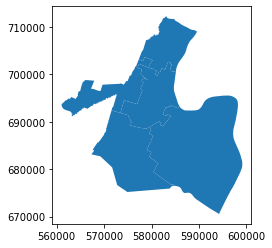

In [192]:
wards.plot()

In [193]:
wards.head()

,RECORD_NO,MSLINK,FIPSSTCO,FIPSCO,FIPS,SSN,MUN,COUNTY,MUNCOUNTY,WARD_NAME,SQFT_WARD,ACRE_WARD,SQMI_WARD,LF_WARD,SQFT_LAND,ACRE_LAND,SQMI_LAND,LF_LAND,SQFT_WATER,ACRE_WATER,SQMI_WATER,LF_WATER,LF_WTRFRNT,POP_2010,POP_2000,POP_1990,POP_1980,MAP_LABEL,CouncilMem,CouncilM_1,Shape_STAr,Shape_STLe,geometry
0,2,2,34037,37,51000,714,NEWARK CITY,ESSEX,NEWARK CITY ESSEX,WEST,76051703,1745.906854,2.727979,77159,76051703,1745.906854,2.727979,77159,0,0.00,0.00,0,0,55224,0,0,0,WEST WARD,None,None,7.605170e+07,77158.568031,"POLYGON ((561008.720 693662.098, 561043.847 69..."
1,1,1,34037,37,51000,714,NEWARK CITY,ESSEX,NEWARK CITY ESSEX,NORTH,78151114,1794.102712,2.803285,48295,75918323,1742.844877,2.723195,48152,2232791,51.26,0.08,34741,17299,55652,0,0,0,NORTH WARD,None,None,7.815111e+07,48294.833024,"POLYGON ((577304.999 703156.813, 577954.394 70..."
2,3,3,34037,37,51000,714,NEWARK CITY,ESSEX,NEWARK CITY ESSEX,CENTRAL,96203391,2208.525960,3.450822,62750,94756036,2175.299262,3.398905,62681,1447355,33.23,0.05,15831,7878,53075,0,0,0,CENTRAL WARD,None,None,9.620339e+07,62750.206980,"POLYGON ((573428.856 691848.616, 574194.345 69..."
3,5,5,34037,37,51000,714,NEWARK CITY,ESSEX,NEWARK CITY ESSEX,SOUTH,150783623,3461.515671,5.408618,61862,150783623,3461.515671,5.408618,61862,0,0.00,0.00,0,0,55673,0,0,0,SOUTH WARD,None,None,1.507836e+08,61861.643505,"POLYGON ((567307.224 683136.009, 567885.912 68..."
4,4,4,34037,37,51000,714,NEWARK CITY,ESSEX,NEWARK CITY ESSEX,EAST,329653943,7567.813200,11.824708,83309,277057192,6360.357938,9.938059,99652,52596751,1207.46,1.89,114942,65642,57516,0,0,0,EAST WARD,None,None,3.296539e+08,83309.180974,"POLYGON ((578975.814 684001.268, 579256.378 68..."


## Plotting

In [189]:
neighborhoods.plot()


ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 432x288 with 1 Axes>

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

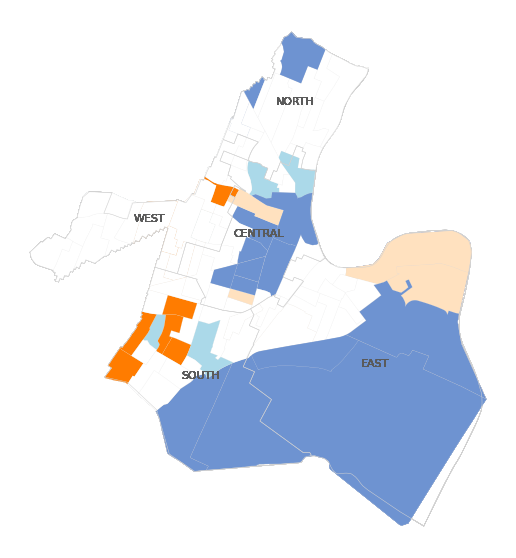

In [196]:
#Institutional Investor Rentals
moran_list = [moran2000_loc_inst_inv_rent,moran2001_loc_inst_inv_rent,moran2002_loc_inst_inv_rent,
             moran2003_loc_inst_inv_rent,moran2004_loc_inst_inv_rent,moran2005_loc_inst_inv_rent,
             moran2006_loc_inst_inv_rent,moran2007_loc_inst_inv_rent,moran2008_loc_inst_inv_rent, moran2009_loc_inst_inv_rent,
             moran2010_loc_inst_inv_rent,moran2011_loc_inst_inv_rent,moran2012_loc_inst_inv_rent,
             moran2013_loc_inst_inv_rent,moran2014_loc_inst_inv_rent,moran2015_loc_inst_inv_rent,
             moran2016_loc_inst_inv_rent,moran2017_loc_inst_inv_rent,moran2018_loc_inst_inv_rent]
files_list = ['inst_inv_rent2000.png','inst_inv_rent2001.png','inst_inv_rent2002.png','inst_inv_rent2003.png',
             'inst_inv_rent2004.png','inst_inv_rent2005.png','inst_inv_rent2006.png','inst_inv_rent2007.png',
             'inst_inv_rent2008.png','inst_inv_rent2009.png',
             'inst_inv_rent2010.png','inst_inv_rent2011.png','inst_inv_rent2012.png','inst_inv_rent2013.png',
             'inst_inv_rent2014.png','inst_inv_rent2015.png','inst_inv_rent2016.png','inst_inv_rent2017.png',
             'inst_inv_rent2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Inst_Rent/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
findfont: Font family ['Akkurat Pro'] not found. Falling back to DejaVu Sans.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has

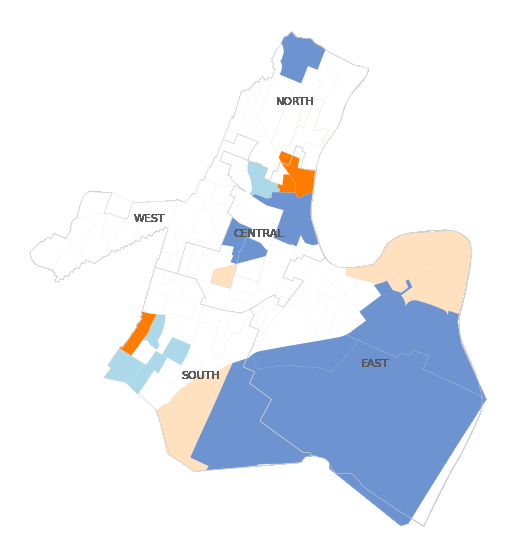

In [198]:
#Non-Institutional Investor Rentals
moran_list = [moran2000_loc_non_inst_inv_rent,moran2001_loc_non_inst_inv_rent,moran2002_loc_non_inst_inv_rent,
             moran2003_loc_non_inst_inv_rent,moran2004_loc_non_inst_inv_rent,moran2005_loc_non_inst_inv_rent,
             moran2006_loc_non_inst_inv_rent,moran2007_loc_non_inst_inv_rent,moran2008_loc_non_inst_inv_rent, moran2009_loc_non_inst_inv_rent,
             moran2010_loc_non_inst_inv_rent,moran2011_loc_non_inst_inv_rent,moran2012_loc_non_inst_inv_rent,
             moran2013_loc_non_inst_inv_rent,moran2014_loc_non_inst_inv_rent,moran2015_loc_non_inst_inv_rent,
             moran2016_loc_non_inst_inv_rent,moran2017_loc_non_inst_inv_rent,moran2018_loc_non_inst_inv_rent]
files_list = ['non_inst_inv_rent2000.png','non_inst_inv_rent2001.png','non_inst_inv_rent2002.png','non_inst_inv_rent2003.png',
             'non_inst_inv_rent2004.png','non_inst_inv_rent2005.png','non_inst_inv_rent2006.png','non_inst_inv_rent2007.png',
             'non_inst_inv_rent2008.png','non_inst_inv_rent2009.png',
             'non_inst_inv_rent2010.png','non_inst_inv_rent2011.png','non_inst_inv_rent2012.png','non_inst_inv_rent2013.png',
             'non_inst_inv_rent2014.png','non_inst_inv_rent2015.png','non_inst_inv_rent2016.png','non_inst_inv_rent2017.png',
             'non_inst_inv_rent2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Non_Inst_Rent/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

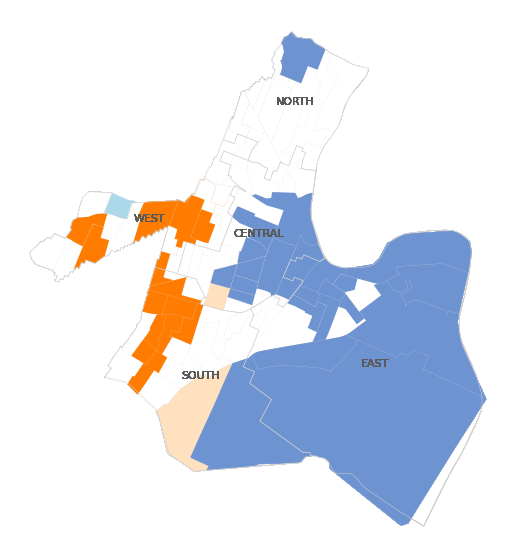

In [199]:
#Institutional Investor Flips
moran_list = [moran2000_loc_inst_inv_flip,moran2001_loc_inst_inv_flip,moran2002_loc_inst_inv_flip,
             moran2003_loc_inst_inv_flip,moran2004_loc_inst_inv_flip,moran2005_loc_inst_inv_flip,
             moran2006_loc_inst_inv_flip,moran2007_loc_inst_inv_flip,moran2008_loc_inst_inv_flip, moran2009_loc_inst_inv_flip,
             moran2010_loc_inst_inv_flip,moran2011_loc_inst_inv_flip,moran2012_loc_inst_inv_flip,
             moran2013_loc_inst_inv_flip,moran2014_loc_inst_inv_flip,moran2015_loc_inst_inv_flip,
             moran2016_loc_inst_inv_flip,moran2017_loc_inst_inv_flip,moran2018_loc_inst_inv_flip]
files_list = ['inst_inv_flip2000.png','inst_inv_flip2001.png','inst_inv_flip2002.png','inst_inv_flip2003.png',
             'inst_inv_flip2004.png','inst_inv_flip2005.png','inst_inv_flip2006.png','inst_inv_flip2007.png',
             'inst_inv_flip2008.png','inst_inv_flip2009.png',
             'inst_inv_flip2010.png','inst_inv_flip2011.png','inst_inv_flip2012.png','inst_inv_flip2013.png',
             'inst_inv_flip2014.png','inst_inv_flip2015.png','inst_inv_flip2016.png','inst_inv_flip2017.png',
             'inst_inv_flip2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Inst_Flip/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

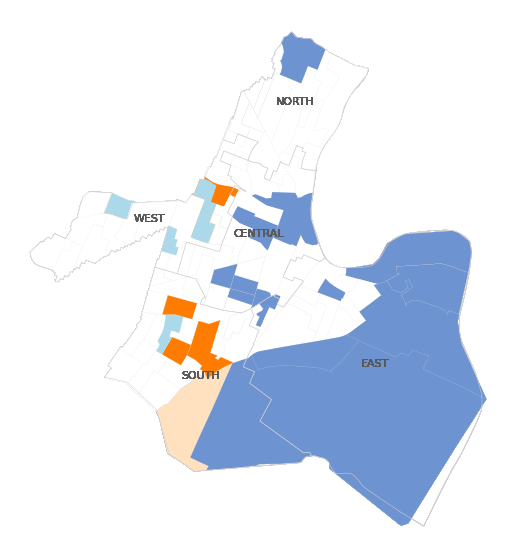

In [201]:
#Non-Institutional Investor Flips
moran_list = [moran2000_loc_non_inst_inv_flip,moran2001_loc_non_inst_inv_flip,moran2002_loc_non_inst_inv_flip,
             moran2003_loc_non_inst_inv_flip,moran2004_loc_non_inst_inv_flip,moran2005_loc_non_inst_inv_flip,
             moran2006_loc_non_inst_inv_flip,moran2007_loc_non_inst_inv_flip,moran2008_loc_non_inst_inv_flip, moran2009_loc_non_inst_inv_flip,
             moran2010_loc_non_inst_inv_flip,moran2011_loc_non_inst_inv_flip,moran2012_loc_non_inst_inv_flip,
             moran2013_loc_non_inst_inv_flip,moran2014_loc_non_inst_inv_flip,moran2015_loc_non_inst_inv_flip,
             moran2016_loc_non_inst_inv_flip,moran2017_loc_non_inst_inv_flip,moran2018_loc_non_inst_inv_flip]
files_list = ['non_inst_inv_flip2000.png','non_inst_inv_flip2001.png','non_inst_inv_flip2002.png','non_inst_inv_flip2003.png',
             'non_inst_inv_flip2004.png','non_inst_inv_flip2005.png','non_inst_inv_flip2006.png','non_inst_inv_flip2007.png',
             'non_inst_inv_flip2008.png','non_inst_inv_flip2009.png',
             'non_inst_inv_flip2010.png','non_inst_inv_flip2011.png','non_inst_inv_flip2012.png','non_inst_inv_flip2013.png',
             'non_inst_inv_flip2014.png','non_inst_inv_flip2015.png','non_inst_inv_flip2016.png','non_inst_inv_flip2017.png',
             'non_inst_inv_flip2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Non_Inst_Flip/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

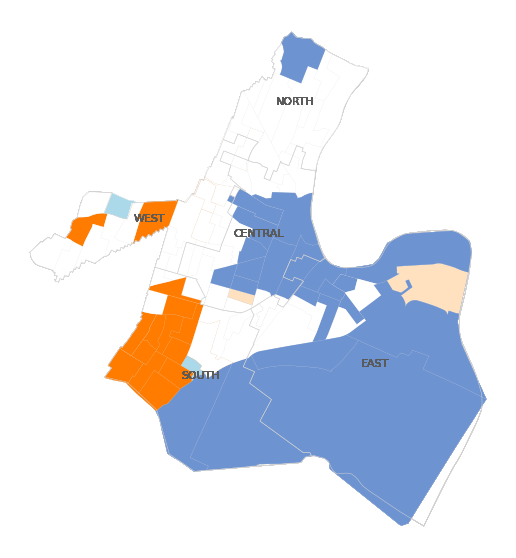

In [202]:
#Non Investor / Owner-Occ
moran_list = [moran2000_loc_non_inv,moran2001_loc_non_inv,moran2002_loc_non_inv,
             moran2003_loc_non_inv,moran2004_loc_non_inv,moran2005_loc_non_inv,
             moran2006_loc_non_inv,moran2007_loc_non_inv,moran2008_loc_non_inv, moran2009_loc_non_inv,
             moran2010_loc_non_inv,moran2011_loc_non_inv,moran2012_loc_non_inv,
             moran2013_loc_non_inv,moran2014_loc_non_inv,moran2015_loc_non_inv,
             moran2016_loc_non_inv,moran2017_loc_non_inv,moran2018_loc_non_inv]
files_list = ['non_inv2000.png','non_inv2001.png','non_inv2002.png','non_inv2003.png',
             'non_inv2004.png','non_inv2005.png','non_inv2006.png','non_inv2007.png',
             'non_inv2008.png','non_inv2009.png',
             'non_inv2010.png','non_inv2011.png','non_inv2012.png','non_inv2013.png',
             'non_inv2014.png','non_inv2015.png','non_inv2016.png','non_inv2017.png',
             'non_inv2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Non_Inv/'+files_list[i], dpi=300)